# Shapley Feedback for HandGesture Recognition

This project aims to improve upon a previously developed hand gesture recognition [system](https://github.com/aonai/long_term_EMG_myo/tree/main) by incorporating Explainable AI techniques. The goal is to enhance the model's interpretability and transparency. 
  
Original model by UlysseCoteAllard https://github.com/UlysseCoteAllard/LongTermEMG   
Dataset recorded by https://github.com/Suguru55/Wearable_Sensor_Long-term_sEMG_Dataset 


### Notes 
* weights for ConvNet are total of 3 training models, 3 for each subject
* weights for DANN and SCADANN are total of 2 trianing models, 2 for each subject 


* training examples for ConvNet should have shape (1, 3, 40, 572, 4, 8, 10)
* training examples for TSD should have shape (1, 3, 40, 572, 252)
* training labels should have shape  (1, 3, 40, 572)


* location 0, 1, and 2 corresponds to neutral position, inward rotation, and outward roation respectively
* session mentioned below are wearing location, so number of sessions is 3

## Importing Libraries

In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 
sys.path.append("path to the directory containing the code")

In [2]:
code_dir = "path to the directory containing the code"
os.chdir(code_dir)
from long_term_EMG_myo.PrepareAndLoadData.process_data import read_data_training

# 0. Prepare Data for ConvNet

### specify the directories used for running the code:
* `code_dir`: path to long_term_EMG_myo library
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape   
    (controlling_factor_1 x controlling_factor_2 x num_sessions_per_gesture x #examples_window*#mov(26*22=572) x processed_channel_shape(252 for TSD, (4,8,10) for ConvNet)
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for the first controlling factor.
    * weights for base model (TSD or ConvNet) contain m set of training model
    * weights for DANN and SCADANN contain m-1 set of trianing model (these models are trianed based on TSD, so they do not have a best_state_0.pt model). 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of dataset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving



* use `read_data_training` to process raw dataset
        

In [3]:
data_dir = "Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "Processed_datasets_ConvNet"

path_ConvNet ="TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNet"
save_ConvNet = "TrainingsAndEvaluations/ForTrainingSessions/results"

path_ConvNet_DANN ="TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNetDANN"
save_ConvNet_DANN = "TrainingsAndEvaluations/ForTrainingSessions/results"

path_ConvNet_SCADANN ="TrainingsAndEvaluations/ForTrainingSessions/Weights_ConvNet/ConvNetSCADANN"
save_ConvNet_SCADANN = "TrainingsAndEvaluations/ForTrainingSessions/results2"



In [4]:
#Processes raw data and saves it in the processed_data_dir
read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=1, sessions_to_include =[0], switch=2 ,spectrogram=True)

Loading and preparing Training datasets...
session  0  --- process data in days  [1, 4, 9, 10, 12, 13, 19, 26, 27, 29]
index_participant_list  [1, 2]
READ  Sub 1 _Loc 0 _Day 1
examples_per_session =  (1, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 4
examples_per_session =  (2, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 9
examples_per_session =  (3, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 10
examples_per_session =  (4, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 12
examples_per_session =  (5, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 13
examples_per_session =  (6, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 19
examples_per_session =  (7, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 26
examples_per_session =  (8, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 27
examples_per_session =  (9, 4, 572, 4, 8, 10)
READ  Sub 1 _Loc 0 _Day 29
examples_per_session =  (10, 4, 572, 4, 8, 10)
@ traning sessions =  (1, 10, 4, 572, 4, 8, 10)
READ  Sub 2 _Loc 0 _Day 1
examples_per_session =  (1, 4, 572, 4, 8, 10)
RE

In [4]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)
#Load the data
examples_datasets_train_ConvNet = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train_ConvNet))
labels_datasets_train_ConvNet = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train_ConvNet))

traning examples  (2, 10, 4, 572, 4, 8, 10)
traning labels  (2, 10, 4, 572)


### Specify params used for training and testing ConvNet
During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for ConvNet model and dataloaders

* `filter_size`: kernel size of ConvNet model; should be a 2d list of shape (m, 2), where m (4) is number of levels
* `num_kernels_ConvNet`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)

In [5]:
filter_size = [[3, 7], [3, 2], [3, 2], [2, 2]]
num_kernels_ConvNet = [16, 32, 64, 128]

### Additional params used for training and testing


* `num_kernels`: list of integers defining number of neurons used in each linear layer (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        
number_of_cycles_total=np.shape(examples_datasets_train_ConvNet[0][0])[0]              
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128                           
learning_rate=0.002515

number_of_cycles_total  4


# 1.a. ConvNet
* `train_fine_tuning`: used to train data using a base model (ConvNet)
    * running this function will save num_sessions sets of ConvNet model weights (each is fine tuned based on the previous training)  
    
* `test_standard_model_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (num_session x 40 x 572 x 4 x 8 x 10)
* each session has shape (40 x 572 x 4 x 8 x 10)
* put these data into on group ends up with shape (40*572=22880, 4, 8, 10)
    * shuffle on group of data and put into dataloaders
    * each participant should have num_sessions sets of dataloaders, each correspond to one session

In [7]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_standard_model_on_training_sessions, train_fine_tuning

In [8]:
from long_term_EMG_myo.Models.spectrogram_ConvNet import SpectrogramConvNet 

In [9]:
from long_term_EMG_myo.PrepareAndLoadData.load_dataset_in_dataloader import load_dataloaders_training_sessions

In [10]:
# Use existing training routine to get base weights
train_fine_tuning(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
                  num_kernels=num_kernels_ConvNet, path_weight_to_save_to=path_ConvNet,
                  number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
                  batch_size=batch_size, learning_rate=learning_rate,
                  neural_net="Spectrogram", filter_size=filter_size)



GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
  

In [34]:
# After training: load the model
model = SpectrogramConvNet(number_of_class=number_of_classes, num_kernels=num_kernels_ConvNet,
                           kernel_size=filter_size)
checkpoint = torch.load(path_ConvNet + "/participant_0/best_state_0.pt") #load models based on what you want to evaluate
model.load_state_dict(checkpoint['state_dict'])
model.eval()


SpectrogramConvNet(
  (_network_TCN): ModuleList(
    (0): ConvBlock(
      (conv1): Conv2d(4, 16, kernel_size=(3, 7), stride=(1, 1))
      (batch_norm1): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout2d(p=0.5, inplace=False)
      (net): Sequential(
        (0): Conv2d(4, 16, kernel_size=(3, 7), stride=(1, 1))
        (1): BatchNorm2d(16, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout2d(p=0.5, inplace=False)
      )
      (relu): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 2), stride=(1, 1))
      (batch_norm1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout2d(p=0.5, inplace=False)
    

In [35]:
import torch
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_channels = 8  # 8 EMG channels

# Get subset from training dataset
X_subset = []
Y_subset = []
sample_size = 100
train_loader = load_dataloaders_training_sessions(
    examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
    number_of_cycle_for_first_training=number_of_cycles_total,
    number_of_cycles_rest_of_training=number_of_cycles_total,
    number_of_cycles_total=number_of_cycles_total,
    batch_size=128, shuffle=True, get_validation_set=False)[0]

train_loader_first = train_loader[0][0] # change this if you want another participant train_loader[participant][session]
for i, (inputs, labels) in enumerate(train_loader_first):
    for x, y in zip(inputs, labels):
        X_subset.append(x.unsqueeze(0))
        Y_subset.append(y)
        if len(X_subset) >= sample_size:
            break
    if len(X_subset) >= sample_size:
        break

X_subset = torch.cat(X_subset).to(device)  # [sample_size, 4, 8, 10]
Y_subset = torch.tensor(Y_subset).to(device)

def get_model_logits(model, x):
    model.eval()
    with torch.no_grad():
        logits = model(x)
    return logits

def zero_channels(x):
    x_zero = torch.zeros_like(x)
    return x_zero

num_gestures = number_of_classes  # 22 gestures
shapley_values_per_gesture = np.zeros((num_gestures, num_channels))  # shape: [22, 8]
num_subsets=100
for sample_idx in range(sample_size):
    x_sample = X_subset[sample_idx:sample_idx+1]  # shape: [1, 4, 8, 10]
    y_sample = Y_subset[sample_idx].item()  # current gesture label

    # baseline (no EMG channels)
    baseline_out = get_model_logits(model, zero_channels(x_sample))
    baseline_score = baseline_out[0, y_sample].item()

    # full input
    full_out = get_model_logits(model, x_sample)
    full_score = full_out[0, y_sample].item()
    
    # Compute channel contributions for this gesture
    channel_contribs = np.zeros(num_channels)
    channels_list = list(range(num_channels))
    
    for c in channels_list:
        marginal_sum = 0.0
        for _ in range(num_subsets):
            # Same masking logic as before
            others = [ch for ch in channels_list if ch != c]
            subset_size = random.randint(0, len(others))
            chosen_subset = random.sample(others, subset_size)

            mask_with_c = np.zeros(num_channels, dtype=bool)
            mask_with_c[chosen_subset] = True
            mask_with_c[c] = True

            mask_without_c = np.zeros(num_channels, dtype=bool)
            mask_without_c[chosen_subset] = True

            x_with_c = x_sample.clone()
            x_without_c = x_sample.clone()
            
            x_with_c[:, :, ~mask_with_c, :] = 0.0
            x_without_c[:, :, ~mask_without_c, :] = 0.0

            with_c_out = get_model_logits(model, x_with_c)
            without_c_out = get_model_logits(model, x_without_c)

            with_c_score = with_c_out[0, y_sample].item()
            without_c_score = without_c_out[0, y_sample].item()

            marginal_contribution = with_c_score - without_c_score
            marginal_sum += marginal_contribution

        channel_contribs[c] = marginal_sum / num_subsets
    
    # Add contributions to the gesture-specific Shapley values
    shapley_values_per_gesture[y_sample] += channel_contribs

# Average Shapley values for each gesture
gesture_counts = np.zeros(num_gestures)
for y in Y_subset:
    gesture_counts[y.item()] += 1

for g in range(num_gestures):
    if gesture_counts[g] > 0:
        shapley_values_per_gesture[g] /= gesture_counts[g]

# Print results for each gesture
for gesture in range(num_gestures):
    print(f"\nGesture {gesture} EMG channel contributions:")
    print(shapley_values_per_gesture[gesture])
    
    #normalize values for this gesture
    normalized = shapley_values_per_gesture[gesture] / np.sum(shapley_values_per_gesture[gesture])
    print(f"Normalized contributions: {normalized}")

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  4
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY 

In [36]:
import numpy as np

# Create a matrix of channel contributions [22 gestures × 8 channels]
import numpy as np

# Normalized contributions from the user's data (22 gestures, each with an 8-channel array)
normalized_contributions = np.array([
    [ 0.2405995,   0.05276877,  0.82478855,  0.2801991,  -0.71200399, -0.44294179,  0.63033751,  0.12625235],  # Gesture 0
    [ 2.87947215e-01, -3.43653388e-01, -1.49320550e-01,  5.87903376e-02, -2.09029519e-01,  5.72551326e-05,  1.02478810e+00,  3.30420549e-01],  # Gesture 1
    [-0.03270394, -0.34244382,  0.96713427,  0.51936493,  0.02957434, -0.08599463, -0.04022268, -0.01470848],  # Gesture 2
    [-0.03829544, -0.14513933,  0.74385207,  0.01195588,  0.7094473,  -0.37816369,  0.22048708, -0.12414386],  # Gesture 3
    [-0.22885068,  0.52540056,  0.42670164, -0.28338417,  0.25536473, -0.26257779,  0.05020672,  0.517139],    # Gesture 4
    [-0.28247843,  0.20250779,  0.09236866, -0.20760195, -0.0279462,   1.02846854,  0.53094043, -0.33625884],  # Gesture 5
    [-0.62007804,  1.0935741,   1.61518106, -1.29170314,  0.5579543,   0.14879719, -0.29264685, -0.21107862], # Gesture 6
    [ 1.19109472, -0.13682491, -0.45385666,  0.38198007, -0.05505353, -0.07543928, -0.07457451,  0.22267409], # Gesture 7
    [-0.04363208,  0.15025844, -0.18173453, -0.07286976, -0.09223664,  0.71823621,  0.6170138,  -0.09503543], # Gesture 8
    [-0.06477126, -0.0599678,   0.24241562,  0.65250445, -0.39339128,  0.80879994, -0.06817981, -0.11740987], # Gesture 9
    [-0.08191223, -0.24055033,  0.36121567,  0.13966297, -0.26759684,  0.46955427,  1.04926776, -0.42964126], # Gesture 10
    [-9.29943994e-02,  3.77819047e-01,  4.38875807e-01, -2.15180192e-01,  6.06757584e-02, -3.33548166e-04,  2.47193469e-01,  1.83944057e-01], # Gesture 11
    [-0.11044497, -0.06712454,  0.72288701, -0.14767166,  0.08503589, -0.40022501,  0.31957386,  0.59796941], # Gesture 12
    [-0.11178349,  0.00452865,  1.18706234, -0.04640886,  0.07429818,  0.02653798, -0.13947862,  0.00524381], # Gesture 13
    [-0.14952479,  0.00194074,  1.22326502, -0.0682764,   0.29039932, -0.08660457, -0.13050691, -0.08069242], # Gesture 14
    [-0.45006616,  0.99654351,  0.4489865,  -0.52631962,  0.41933404, -0.23195919, -0.52959229,  0.87307322], # Gesture 15
    [ 0.85929746, -0.02429919, -0.19743514,  0.02303109, -0.00309459, -0.11465077,  0.2610272,   0.19612393], # Gesture 16
    [ 0.14996391, -0.2157951,  -0.3572905,   1.56848605, -0.02825706, -0.03224541, -0.08002709, -0.00483479], # Gesture 17
    [ 0.2005309,  -0.0998843,  -0.32481537,  0.98268967,  0.05979799, -0.27685619,  0.54848302, -0.08994573], # Gesture 18
    [ 0.31181152,  0.42046471, -0.16687666, -0.09812362,  0.1654644,  -0.20207369, -0.16566747,  0.73500082], # Gesture 19
    [ 0.7886023,   0.08645286, -0.37615385,  0.22381249, -0.2401891,   0.80962602, -0.09459429, -0.19755643], # Gesture 20
    [ 0.82955905,  0.35319728, -0.05318973,  0.17335268, -0.04515888,  0.05682119, -0.2479255,  -0.06665607]  # Gesture 21
])

print("Normalized Contributions Matrix (22x8):")
print(normalized_contributions)

Normalized Contributions Matrix (22x8):
[[ 2.40599500e-01  5.27687700e-02  8.24788550e-01  2.80199100e-01
  -7.12003990e-01 -4.42941790e-01  6.30337510e-01  1.26252350e-01]
 [ 2.87947215e-01 -3.43653388e-01 -1.49320550e-01  5.87903376e-02
  -2.09029519e-01  5.72551326e-05  1.02478810e+00  3.30420549e-01]
 [-3.27039400e-02 -3.42443820e-01  9.67134270e-01  5.19364930e-01
   2.95743400e-02 -8.59946300e-02 -4.02226800e-02 -1.47084800e-02]
 [-3.82954400e-02 -1.45139330e-01  7.43852070e-01  1.19558800e-02
   7.09447300e-01 -3.78163690e-01  2.20487080e-01 -1.24143860e-01]
 [-2.28850680e-01  5.25400560e-01  4.26701640e-01 -2.83384170e-01
   2.55364730e-01 -2.62577790e-01  5.02067200e-02  5.17139000e-01]
 [-2.82478430e-01  2.02507790e-01  9.23686600e-02 -2.07601950e-01
  -2.79462000e-02  1.02846854e+00  5.30940430e-01 -3.36258840e-01]
 [-6.20078040e-01  1.09357410e+00  1.61518106e+00 -1.29170314e+00
   5.57954300e-01  1.48797190e-01 -2.92646850e-01 -2.11078620e-01]
 [ 1.19109472e+00 -1.36824910

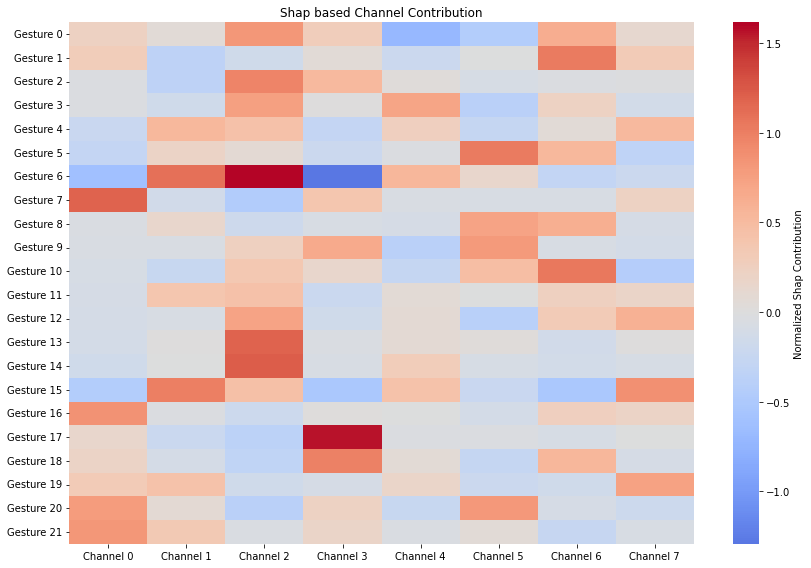

In [37]:
#Heatmap of the normalized contributions per gesture and channel
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(normalized_contributions, 
            xticklabels=[f'Channel {i}' for i in range(8)],
            yticklabels=[f'Gesture {i}' for i in range(22)],
            cmap='coolwarm', center=0,
            cbar_kws={'label': 'Normalized Shap Contribution'})
plt.title('Shap based Channel Contribution')
plt.tight_layout()
plt.savefig('channel_contributions_heatmap.png')
plt.show()

In [36]:

model.eval()
for param in model.parameters():
    param.requires_grad = True

# Get the first conv layer
first_conv = model._network_TCN[0].conv1
print(first_conv)

with torch.no_grad():
    # first_conv.weight shape: [16, 4, 3, 7]
    # Create a weight adjustment mask based on channel contributions per gesture
    for gesture in range(num_gestures):
        # Get channel contributions for this gesture
        gesture_contributions = shapley_values_per_gesture[gesture]
        
        # Apply these contributions to scale the weights
        # This will emphasize positive contributions and de-emphasize negative ones
        for c in range(num_channels):  # 8 EMG channels
            scaling_factor = 1.0 + gesture_contributions[c]  # Increase/decrease based on contribution
            # Apply to the kernel positions that process this EMG channel
            kernel_height = first_conv.weight.shape[2]
            for h in range(kernel_height):
                if c+h < num_channels:
                    first_conv.weight[:, :, h, :] *= scaling_factor

# Save the modified model, do the same with other participants
torch.save(model.state_dict(), path_ConvNet + "/participant_0/shapley_improved_model.pt")

Conv2d(4, 16, kernel_size=(3, 7), stride=(1, 1))


In [37]:
import torch.nn as nn

In [40]:
# Freeze all layers except last FC
for name, param in model.named_parameters():
    # Identify last FC layer
    if '_output' not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Load training/validation data
train_loaders, val_loaders, _ = load_dataloaders_training_sessions(
    examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
    number_of_cycle_for_first_training=number_of_cycles_total,
    number_of_cycles_rest_of_training=number_of_cycles_total,
    number_of_cycles_total=number_of_cycles_total, batch_size=batch_size,
    shuffle=True, get_validation_set=True)

train_loader = train_loaders[0][0] # change this if you want another participant train_loader[participant][session]
val_loader = val_loaders[0][0] # change this if you want another participant val_loader[participant][session]

# Add early stopping parameters
num_finetune_epochs = 100
patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

for epoch in range(num_finetune_epochs):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = running_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            val_total += labels.size(0)
    
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch}: Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), path_ConvNet + "/participant_0/shapley_improved_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping! No improvement for {patience} epochs")
            print(f"Best validation loss was {best_val_loss:.4f} at epoch {best_epoch}")
            break

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
  

In [41]:
# Test the fine-tuned model
algo_name = "standard_ConvNet"
test_loaders = test_standard_model_on_training_sessions(examples_datasets_train_ConvNet,
                                                         labels_datasets_train_ConvNet,
                                                         num_neurons=num_kernels_ConvNet,
                                                         use_only_first_training=True,
                                                         path_weights=path_ConvNet,
                                                         save_path=save_ConvNet,
                                                         algo_name=algo_name,
                                                         number_of_cycles_total=number_of_cycles_total,
                                                         number_of_classes=number_of_classes,
                                                         cycle_for_test=3,
                                                         neural_net="Spectrogram",
                                                         filter_size=filter_size)
# Evaluate improvements in accuracy.


GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (22

In [11]:
algo_name = "standard_ConvNet"
results_filename = save_ConvNet + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_acc = results[0]
ConvNet_acc_overall = np.mean(ConvNet_acc)
ConvNet_df = pd.DataFrame(ConvNet_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_acc.shape[0])])
ConvNet_df

Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.604895      0.737762
Loc_2      0.503497      0.756993
Loc_3      0.545455      0.732517
Loc_4      0.505245       0.79021
Loc_5           0.5      0.772727
Loc_6      0.576923      0.685315
Loc_7       0.66958      0.744755
Loc_8       0.54021      0.534965
Loc_9      0.674825      0.711538

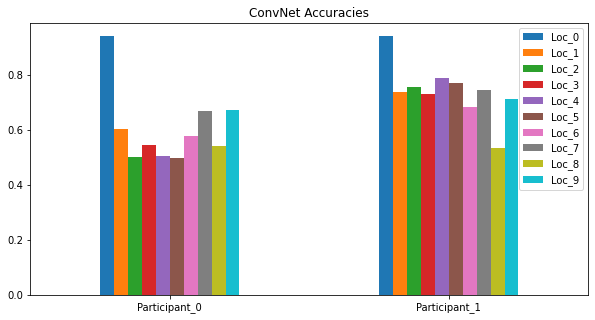

In [12]:
ConvNet_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet Accuracies")
plt.show()

In [13]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [14]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc1_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_ConvNet, algo_name=algo_name)
df = pd.read_csv(save_ConvNet+'/'+algo_name+'.csv')
df

ground_truths  =  (2, 10)
predictions =  (2, 10)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 20)


Unnamed: 0  Loc1_Sub0_Day0  Loc1_Sub0_Day1  Loc1_Sub0_Day2  Loc1_Sub0_Day3  \
0          M0        1.000000        1.000000        1.000000        1.000000   
1          M1        1.000000        0.038462        0.884615        0.653846   
2          M2        0.576923        0.000000        0.000000        0.000000   
3          M3        1.000000        0.692308        0.730769        1.000000   
4          M4        0.923077        0.192308        0.000000        0.115385   
5          M5        1.000000        1.000000        0.384615        0.807692   
6          M6        0.923077        0.846154        0.692308        1.000000   
7          M7        1.000000        0.884615        0.769231        1.000000   
8          M8        0.961538        0.846154        0.576923        0.769231   
9          M9        1.000000        0.230769        0.692308        0.500000   
10        M10        1.000000        0.500000        0.076923        0.769231   
11        M11        0.961538        0.115385        0.000000        0.000000   
12        M12        0.769231        0.000000        0.000000        0.230769   
13        M13        0.730769        0.615385        0.538462        0.269231   
14        M14        0.923077        0.269231        0.307692        0.076923   
15        M15        1.000000        0.153846        0.000000        0.230769   
16        M16        1.000000        1.000000        0.807692        0.346154   
17        M17        1.000000        1.000000        1.000000        1.000000   
18        M18        1.000000        1.000000        0.423077        0.538462   
19        M19        0.961538        0.923077        1.000000        1.000000   
20        M20        1.000000        1.000000        0.230769        0.000000   
21        M21        1.000000        1.000000        0.961538        0.692308   
22       Mean        0.942308        0.604895        0.503497        0.545455   

    Loc1_Sub0_Day4  Loc1_Sub0_Day5  Loc1_Sub0_Day6  Loc1_Sub0_Day7  \
0         1.000000        1.000000        1.000000        1.000000   
1         0.115385        1.000000        0.961538        1.000000   
2         0.000000        0.076923        0.423077        0.000000   
3         0.846154        1.000000        0.961538        0.961538   
4         0.000000        0.192308        0.461538        0.115385   
5         1.000000        0.884615        0.000000        0.884615   
6         0.961538        0.961538        0.961538        1.000000   
7         1.000000        0.923077        0.730769        0.653846   
8         0.384615        0.615385        0.961538        0.961538   
9         0.000000        0.000000        0.000000        1.000000   
10        0.000000        0.000000        0.000000        0.538462   
11        0.000000        0.000000        0.000000        0.500000   
12        0.038462        0.692308        0.500000        0.000000   
13        0.500000        0.000000        0.230769        0.653846   
14        0.076923        0.153846        0.153846        0.038462   
15        0.692308        0.230769        0.192308        0.307692   
16        0.538462        0.269231        0.846154        0.884615   
17        1.000000        1.000000        0.961538        1.000000   
18        1.000000        1.000000        0.576923        0.769231   
19        1.000000        0.346154        0.923077        0.961538   
20        0.961538        0.384615        0.846154        0.730769   
21        0.000000        0.269231        1.000000        0.769231   
22        0.505245        0.500000        0.576923        0.669580   

    Loc1_Sub0_Day8  ...  Loc1_Sub1_Day0  Loc1_Sub1_Day1  Loc1_Sub1_Day2  \
0         1.000000  ...        1.000000        1.000000        1.000000   
1         0.653846  ...        0.961538        1.000000        0.538462   
2         0.038462  ...        1.000000        1.000000        1.000000   
3         1.000000  ...        1.000000        1.000000        0.615385   
4 

In [ ]:
overall_acc_df = pd.DataFrame([ConvNet_acc_overall],
                             index = ["ConvNet"],
                             columns = ["Overall_Acc"])
overall_acc_df

# 2.a. ConvNet -> DANN
Train DANN model based on the weights from 1.a. ConvNet
* `train_DANN`: train DANN model using the first set of training weights from base model
    * num_sessions-1 sets of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model
* `train_improved_DANN`: train DANN model using the first set of training weights from base model with shapley feedback
* `test_improved_DANN`: test DANN model with shapley feedback
   

In [20]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN,test_DANN_on_training_sessions

In [11]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import load_checkpoint

In [12]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import DANN_Training

In [13]:
def calculate_marginal_contribution_dann(model, inputs, gesture_label, start_channel, kernel_height, domain_type, num_samples=30):
    """
    Calculate marginal contribution for a group of channels processed by kernel.
    """
    marginal_sum = 0.0
    channels_list = list(range(8))
    
    # Process entire batch together instead of single examples
    with torch.no_grad():
        # Define kernel window channels
        kernel_channels = list(range(start_channel, min(start_channel + kernel_height, 8)))
        other_channels = [ch for ch in channels_list if ch not in kernel_channels]
        
        for _ in range(num_samples):
            # Random subset of other channels
            subset_size = random.randint(0, len(other_channels))
            chosen_subset = random.sample(other_channels, subset_size)
            
            # Create masks
            mask_with_kernel = np.zeros(8, dtype=bool)
            mask_with_kernel[chosen_subset] = True
            mask_with_kernel[kernel_channels] = True
            
            mask_without_kernel = np.zeros(8, dtype=bool)
            mask_without_kernel[chosen_subset] = True
            
            # Apply masks to whole batch
            x_with_kernel = inputs.clone()
            x_without_kernel = inputs.clone()
            x_with_kernel[:, :, ~mask_with_kernel, :] = 0.0
            x_without_kernel[:, :, ~mask_without_kernel, :] = 0.0
            
            if domain_type == 'source':
                pred_with_k, domain_with_k = model(x_with_kernel, get_all_tasks_output=True)
                pred_without_k, domain_without_k = model(x_without_kernel, get_all_tasks_output=True)
                
                # For source, use gesture classification accuracy
                with_k_score = (torch.max(pred_with_k.data, 1)[1] == gesture_label).float().mean()
                without_k_score = (torch.max(pred_without_k.data, 1)[1] == gesture_label).float().mean()
            else:
                # For target, use domain adaptation performance
                _, domain_with_k = model(x_with_kernel, get_all_tasks_output=True)
                _, domain_without_k = model(x_without_kernel, get_all_tasks_output=True)
                
                domain_labels = torch.ones(domain_with_k.size(0), device=inputs.device, dtype=torch.long)
                with_k_score = (torch.max(domain_with_k.data, 1)[1] == domain_labels).float().mean()
                without_k_score = (torch.max(domain_without_k.data, 1)[1] == domain_labels).float().mean()
            
            marginal_contribution = with_k_score - without_k_score
            marginal_sum += marginal_contribution.item()
    
    return marginal_sum / num_samples

def calculate_shapley_dann_values(model, source_loader, target_loader, device, num_gestures=22, 
                                num_channels=8, kernel_height=3):
    """
    Calculate both gesture-specific and domain adaptation Shapley values.
    """
    shapley_values_per_gesture = np.zeros((num_gestures, num_channels))
    shapley_values_target = np.zeros(num_channels)
    samples_per_gesture = {i: 0 for i in range(num_gestures)}
    
    # Process source domain data
    print("Calculating source domain Shapley values...")
    for i, (inputs, labels) in enumerate(source_loader):
        if i >= 5:  # Limit number of batches for calculation
            break
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        for gesture in range(num_gestures):
            gesture_mask = labels == gesture
            if not gesture_mask.any():
                continue
                
            # Process entire batch for this gesture
            gesture_inputs = inputs[gesture_mask]
            if gesture_inputs.size(0) < 2:  # Skip if not enough samples
                continue
                
            for c in range(num_channels - kernel_height + 1):
                contribution = calculate_marginal_contribution_dann(
                    model, gesture_inputs, gesture, c, kernel_height, 'source'
                )
                for k in range(kernel_height):
                    shapley_values_per_gesture[gesture, c + k] += contribution
            samples_per_gesture[gesture] += 1

    # Process target domain data
    print("Calculating target domain Shapley values...")
    target_samples = 0
    for i, (inputs, _) in enumerate(target_loader):
        if i >= 5:  # Limit number of batches
            break
        inputs = inputs.to(device)
        if inputs.size(0) < 2:  # Skip if batch too small
            continue
            
        for c in range(num_channels - kernel_height + 1):
            contribution = calculate_marginal_contribution_dann(
                model, inputs, None, c, kernel_height, 'target'
            )
            for k in range(kernel_height):
                shapley_values_target[c + k] += contribution
        target_samples += 1

    # Normalize values
    for gesture in range(num_gestures):
        if samples_per_gesture[gesture] > 0:
            shapley_values_per_gesture[gesture] /= samples_per_gesture[gesture]
    
    if target_samples > 0:
        shapley_values_target /= target_samples

    return shapley_values_per_gesture, shapley_values_target

def print_gesture_contributions(shapley_values_per_gesture):
    """Print channel contributions for each gesture."""
    for gesture in range(len(shapley_values_per_gesture)):
        print(f"\nGesture {gesture} EMG channel contributions:")
        print(shapley_values_per_gesture[gesture])
        
        # Normalize
        normalized = shapley_values_per_gesture[gesture] / np.abs(shapley_values_per_gesture[gesture]).sum()
        print("Normalized contributions:", normalized)

def modify_weights_dann(model, shapley_values_per_gesture, shapley_values_target, alpha=0.7):
    """
    Modify conv weights using both gesture-specific and domain adaptation importance.
    """
    with torch.no_grad():
        first_conv = model._network_TCN[0].conv1
        # first_conv.weight shape: [16, 4, 3, 7]
        kernel_height = first_conv.weight.shape[2]
        
        # Instead of per-gesture scaling, we'll apply the scaling to all output channels
        for h in range(kernel_height):
            for c in range(8 - kernel_height + 1):
                # Average the gesture contributions
                gesture_scaling = np.mean([np.mean(shapley_values_per_gesture[g, c:c+kernel_height]) 
                                        for g in range(shapley_values_per_gesture.shape[0])])
                domain_scaling = np.mean(shapley_values_target[c:c+kernel_height])
                
                # Weighted combination
                scaling = alpha * gesture_scaling + (1-alpha) * domain_scaling
                
                # Apply scaling to all output channels
                first_conv.weight[:, :, h, :] *= scaling

In [14]:
import os
import time
import copy
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim

def train_improved_dann(examples_datasets_train, labels_datasets_train, num_kernels, 
                       path_weights_to_save_to="Weights_TSD/DANN", batch_size=512,
                       path_weights_fine_tuning="Weights_TSD/TSD",
                       number_of_cycles_total=40, number_of_cycle_for_first_training=None,number_of_classes=22, 
                       learning_rate=0.002515, neural_net="Spectrogram", filter_size=(4, 10)):
    """
    Enhanced DANN training with combined gesture-specific and domain adaptation channel importance.
    """
    participants_train, participants_validation, _ = load_dataloaders_training_sessions(
        examples_datasets_train, labels_datasets_train, batch_size=batch_size,
        number_of_cycles_total=number_of_cycles_total, 
        number_of_cycles_rest_of_training=number_of_cycles_total,
        number_of_cycle_for_first_training=number_of_cycle_for_first_training,
        get_validation_set=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for participant_i in range(len(participants_train)):
        for session_j in range(1, len(participants_train[participant_i])):
            print(f"\nProcessing Participant {participant_i}, Session {session_j}")
            
            # Initialize model
            if neural_net == 'Spectrogram':
                model = SpectrogramConvNet(
                    number_of_class=number_of_classes, 
                    num_kernels=num_kernels,
                    kernel_size=filter_size
                )
            model = model.to(device)
            #  Create optimizer first
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
            # Then create scheduler using the optimizer
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')
            checkpoint = torch.load(f"{path_weights_fine_tuning}/participant_{participant_i}/best_state_0.pt",
                                 map_location=device)
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            scheduler.load_state_dict(checkpoint['scheduler'])
            #  Make sure model is on correct device
            model = model.to(device)
            for state in optimizer.state.values():
                for k, v in state.items():
                    if isinstance(v, torch.Tensor):
                        state[k] = v.to(device)
            # Calculate Shapley values
            print("Calculating Shapley values...")
            shapley_gesture, shapley_target = calculate_shapley_dann_values(
                model,
                participants_train[participant_i][0],  # source
                participants_train[participant_i][session_j],  # target
                device,
                num_gestures=number_of_classes,
                kernel_height=3
            )
            
            # Print contributions
            print_gesture_contributions(shapley_gesture)
            print("\nDomain adaptation channel contributions:")
            print(shapley_target)
            print("Normalized domain contributions:")
            print(shapley_target / np.abs(shapley_target).sum())
            
            # Modify weights
            print("Modifying weights based on channel importance...")
            modify_weights_dann(model, shapley_gesture, shapley_target)
            model = model.to(device)
            # Train DANN
            print("Starting DANN fine-tuning...")
            best_weights = DANN_Training(
                gesture_classifier=model,
                scheduler=scheduler,
                optimizer_classifier=optimizer,
                train_dataset_source=participants_train[participant_i][0],
                train_dataset_target=participants_train[participant_i][session_j],
                validation_dataset_source=participants_validation[participant_i][0],
                crossEntropyLoss=nn.CrossEntropyLoss(),
                patience_increment=10,
                domain_loss_weight=1e-1
            )
            
            # Save model
            save_path = f"{path_weights_to_save_to}/participant_{participant_i}"
            os.makedirs(save_path, exist_ok=True)
            torch.save(best_weights, f"{save_path}/DANN_shapley_improved_state_{session_j}.pt")

In [36]:
def test_improved_dann(examples_datasets_train, labels_datasets_train, num_neurons, path_ConvNet,
                      path_weights_DA, algo_name="DANN_Shapley", across_sub=False,
                      save_path='results', number_of_cycles_total=40,
                      cycle_for_test=3, number_of_classes=22, number_of_cycle_for_first_training=None,
                      neural_net="Spectrogram", filter_size=(4, 10)):
    """
    Test the improved DANN model on training sessions.
    """
    
    _, _, participants_test = load_dataloaders_training_sessions(
        examples_datasets_train, labels_datasets_train,
        number_of_cycles_total=number_of_cycles_total,
        number_of_cycles_rest_of_training=number_of_cycles_total,
        number_of_cycle_for_first_training=number_of_cycle_for_first_training,
        batch_size=128*3, cycle_for_test=cycle_for_test)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    results = {
        'model_outputs': [],
        'predictions': [],
        'ground_truths': [],
        'accuracies': []
    }
    
    for participant_index, dataset_test in enumerate(participants_test):
        participant_results = {key: [] for key in results.keys()}
        
        if neural_net == 'Spectrogram':
            model = SpectrogramConvNet(number_of_class=number_of_classes,
                                     num_kernels=num_neurons,
                                     kernel_size=filter_size)
        model = model.to(device)
        
        for session_index, test_loader in enumerate(dataset_test):
            try:
                if across_sub:
                    try:
                        best_state = torch.load(
                            path_weights_DA + "/participant_%d/DANN_shapley_improved_state_%d.pt" %
                            (0, 1), map_location=device)
                        print(f"Loaded across-subject weights from participant 0")
                    except Exception as e:
                        print(f"Error loading across-subject weights: {e}")
                        continue
                else:
                    if session_index == 0:
                        try:
                            best_state = torch.load(
                                path_ConvNet + "/participant_%d/best_state_%d.pt" %
                                (participant_index, 0), map_location=device)
                            print(f"Loaded standard weights for participant {participant_index}")
                        except Exception as e:
                            print(f"Error loading standard weights for participant {participant_index}: {e}")
                            continue
                    else:
                        try:
                            best_state = torch.load(
                                path_weights_DA + "/participant_%d/DANN_shapley_improved_state_%d.pt" %
                                (participant_index, session_index), map_location=device)
                            print(f"Loaded DANN improved weights for participant {participant_index}, session {session_index}")
                        except Exception as e:
                            print(f"Error loading DANN improved weights for participant {participant_index}, session {session_index}: {e}")
                            continue

                model.load_state_dict(best_state['state_dict'])
                model.eval()
                
                session_outputs = []
                session_preds = []
                session_truth = []
                
                with torch.no_grad():
                    for inputs, labels in test_loader:
                        inputs = inputs.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        
                        session_outputs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                        session_preds.extend(preds.cpu().numpy())
                        session_truth.extend(labels.numpy())
                
                accuracy = np.mean(np.array(session_preds) == np.array(session_truth))
                print(f"Participant {participant_index}, Session {session_index}: Accuracy = {accuracy:.4f}")
                
                participant_results['model_outputs'].append(session_outputs)
                participant_results['predictions'].append(session_preds)
                participant_results['ground_truths'].append(session_truth)
                participant_results['accuracies'].append(accuracy)
                
            except Exception as e:
                print(f"Error processing participant {participant_index}, session {session_index}: {e}")
                continue
        
        for key in results:
            results[key].append(participant_results[key])
    
    accuracies = np.array([acc for acc in results['accuracies']])
    print(f"Overall accuracy: {np.mean(accuracies):.4f}")
    
    try:
        np.save(f"{save_path}/predictions_{algo_name}", 
                np.array((accuracies, 
                         results['ground_truths'],
                         results['predictions'],
                         results['model_outputs']), dtype=object))
        
        with open(f"{save_path}/{algo_name}.txt", "a") as f:
            f.write("Predictions:\n")
            f.write(str(results['predictions']) + '\n')
            f.write("Ground Truth:\n")
            f.write(str(results['ground_truths']) + '\n')
            f.write("Accuracies:\n")
            f.write(str(accuracies) + '\n')
            f.write(f"Overall accuracy: {np.mean(accuracies):.4f}")
            
        print("Results saved successfully")
    except Exception as e:
        print(f"Error saving results: {e}")
    
    return results



In [16]:
train_improved_dann(
    examples_datasets_train_ConvNet,
    labels_datasets_train_ConvNet,
    num_kernels=num_kernels_ConvNet,
    path_weights_fine_tuning=path_ConvNet,
    number_of_classes=number_of_classes,
    number_of_cycles_total=number_of_cycles_total,
    batch_size=batch_size,
    path_weights_to_save_to=path_ConvNet_DANN,
    learning_rate=learning_rate,
    neural_net="Spectrogram",
    filter_size=filter_size
)

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
  

/home/rahulroy/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Calculating target domain Shapley values...

Gesture 0 EMG channel contributions:
[-0.02777778 -0.09039683 -0.15404762 -0.18079365 -0.15928572 -0.14555556
 -0.09103175 -0.04992064]
Normalized contributions: [-0.03090508 -0.10057395 -0.17139073 -0.2011479  -0.17721854 -0.16194261
 -0.10128035 -0.05554084]

Gesture 1 EMG channel contributions:
[-0.02257143 -0.017      -0.00947619  0.01066667  0.00280952  0.02776191
  0.03019048  0.03247619]
Normalized contributions: [-0.14757161 -0.1111457  -0.06195517  0.06973848  0.01836862  0.18150685
  0.19738481  0.21232877]

Gesture 2 EMG channel contributions:
[ 1.00555555e-02  4.75185186e-02  6.91666668e-02  5.02407408e-02
  2.16666669e-03 -1.94074073e-02 -1.05370369e-02  7.40742187e-05]
Normalized contributions: [ 0.04807437  0.22718017  0.33067729  0.24019478  0.01035857 -0.09278442
 -0.05037627  0.00035414]

Gesture 3 EMG channel contributions:
[ 0.00797619  0.00818254  0.02089683  0.01735714  0.0334127  -0.00226984
 -0.00670635 -0.02296825]
N

In [37]:
test_improved_dann(
    examples_datasets_train_ConvNet,
    labels_datasets_train_ConvNet,
    num_neurons=num_kernels_ConvNet,
    path_weights_DA=path_ConvNet_DANN,
    path_ConvNet=path_ConvNet,
    algo_name="ConvNet_DANN_Shapley",
    save_path=save_ConvNet_DANN,
    number_of_cycles_total=number_of_cycles_total,
    number_of_classes=number_of_classes,
    cycle_for_test=3,
    neural_net="Spectrogram",
    filter_size=filter_size)


GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  3
   GOT one group XY  (22

{'model_outputs': [[[array([9.9954373e-01, 3.8547565e-05, 1.2261131e-08, 1.0680350e-05,
           3.7219095e-08, 1.0490683e-04, 2.7251636e-04, 5.3847845e-07,
           2.4387111e-07, 1.2278284e-08, 1.5003403e-07, 1.8370878e-09,
           4.1209830e-07, 7.7584534e-09, 1.3528171e-06, 2.3016793e-05,
           2.8388540e-09, 9.7973304e-07, 9.5897583e-08, 4.9483280e-08,
           1.5078315e-06, 1.1914547e-06], dtype=float32),
    array([9.9953294e-01, 3.7352234e-05, 1.2595766e-08, 1.0001883e-05,
           3.3190489e-08, 1.1380631e-04, 2.7699472e-04, 5.0835865e-07,
           2.5689545e-07, 1.3949850e-08, 1.6051381e-07, 1.8355620e-09,
           3.7593384e-07, 8.1106117e-09, 1.3851553e-06, 2.2179211e-05,
           2.6597464e-09, 9.8481848e-07, 9.3260972e-08, 4.5439720e-08,
           1.6415839e-06, 1.1789353e-06], dtype=float32),
    array([9.99592125e-01, 4.73059517e-05, 1.37006397e-08, 1.05968984e-05,
           2.95747871e-08, 1.05186205e-04, 2.18613073e-04, 7.24758650e-07,
       

## Base DANN model

In [9]:
train_DANN(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet, 
          num_kernels=num_kernels_ConvNet,
          path_weights_fine_tuning=path_ConvNet,
          number_of_classes=number_of_classes,
          number_of_cycles_total = number_of_cycles_total,
          batch_size=batch_size,
          path_weights_to_save_to=path_ConvNet_DANN, 
          learning_rate=learning_rate,
          neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Training/Validation Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Training/Validation Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  a

In [16]:
algo_name = "ConvNet_DANN"
test_DANN_on_training_sessions(examples_datasets_train_ConvNet, labels_datasets_train_ConvNet,
                              num_neurons=num_kernels_ConvNet, path_weights_DA=path_ConvNet_DANN,
                              algo_name=algo_name, save_path = save_ConvNet_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_ConvNet, number_of_classes=number_of_classes,
                              cycle_for_test=3, neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Test Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Test Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572

## Base DANN model results

In [17]:
results_filename = save_ConvNet_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_DANN_acc = results[0]
ConvNet_DANN_acc_overall = np.mean(ConvNet_DANN_acc)
ConvNet_DANN_df = pd.DataFrame(ConvNet_DANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_DANN_acc.shape[0])])
ConvNet_DANN_df

Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.718531      0.828671
Loc_2      0.582168      0.809441
Loc_3      0.666084      0.694056
Loc_4      0.587413      0.770979
Loc_5      0.513986      0.770979
Loc_6      0.617133      0.797203
Loc_7      0.662587      0.795455
Loc_8      0.585664      0.713287
Loc_9      0.736014      0.641608

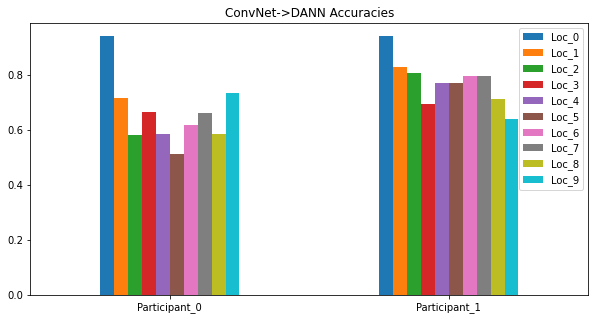

In [18]:
ConvNet_DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet->DANN Accuracies")
plt.show()

In [19]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc1_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_ConvNet_DANN, algo_name=algo_name)
df = pd.read_csv(save_ConvNet_DANN+'/'+algo_name+'.csv')
df

ground_truths  =  (2, 10)
predictions =  (2, 10)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 20)


Unnamed: 0  Loc1_Sub0_Day0  Loc1_Sub0_Day1  Loc1_Sub0_Day2  Loc1_Sub0_Day3  \
0          M0        1.000000        1.000000        1.000000        1.000000   
1          M1        1.000000        0.461538        0.884615        0.846154   
2          M2        0.576923        0.423077        0.000000        0.269231   
3          M3        1.000000        0.807692        0.807692        0.923077   
4          M4        0.923077        0.269231        0.038462        0.500000   
5          M5        1.000000        1.000000        0.769231        0.807692   
6          M6        0.923077        0.884615        0.730769        1.000000   
7          M7        1.000000        0.961538        0.730769        0.961538   
8          M8        0.961538        0.961538        0.923077        1.000000   
9          M9        1.000000        0.269231        0.346154        0.884615   
10        M10        1.000000        0.923077        0.653846        1.000000   
11        M11        0.961538        0.307692        0.000000        0.000000   
12        M12        0.769231        0.269231        0.000000        0.307692   
13        M13        0.730769        1.000000        0.653846        0.730769   
14        M14        0.923077        0.230769        0.307692        0.000000   
15        M15        1.000000        0.076923        0.000000        0.076923   
16        M16        1.000000        1.000000        0.961538        0.884615   
17        M17        1.000000        1.000000        1.000000        1.000000   
18        M18        1.000000        0.961538        0.615385        0.192308   
19        M19        0.961538        1.000000        1.000000        1.000000   
20        M20        1.000000        1.000000        0.423077        0.538462   
21        M21        1.000000        1.000000        0.961538        0.730769   
22       Mean        0.942308        0.718531        0.582168        0.666084   

    Loc1_Sub0_Day4  Loc1_Sub0_Day5  Loc1_Sub0_Day6  Loc1_Sub0_Day7  \
0         1.000000        1.000000        1.000000        1.000000   
1         0.269231        0.692308        1.000000        1.000000   
2         0.692308        0.384615        0.846154        0.000000   
3         0.846154        1.000000        0.692308        0.961538   
4         0.307692        0.000000        0.423077        0.307692   
5         1.000000        0.923077        0.000000        0.884615   
6         1.000000        0.846154        0.961538        1.000000   
7         0.884615        0.615385        0.846154        0.615385   
8         0.846154        0.961538        1.000000        0.961538   
9         0.000000        0.000000        0.038462        1.000000   
10        0.000000        0.000000        0.000000        0.653846   
11        0.076923        0.000000        0.269231        0.000000   
12        0.346154        0.423077        0.500000        0.000000   
13        0.884615        0.576923        0.769231        1.000000   
14        0.000000        0.269231        0.192308        0.000000   
15        0.230769        0.000000        0.192308        0.115385   
16        1.000000        0.538462        0.961538        0.846154   
17        1.000000        1.000000        0.961538        1.000000   
18        1.000000        0.846154        0.615385        0.769231   
19        0.846154        0.653846        0.423077        0.884615   
20        0.692308        0.115385        0.884615        0.807692   
21        0.000000        0.461538        1.000000        0.769231   
22        0.587413        0.513986        0.617133        0.662587   

    Loc1_Sub0_Day8  ...  Loc1_Sub1_Day0  Loc1_Sub1_Day1  Loc1_Sub1_Day2  \
0         1.000000  ...        1.000000        1.000000        1.000000   
1         0.769231  ...        0.961538        1.000000        0.384615   
2         0.538462  ...        1.000000        1.000000        0.961538   
3         1.000000  ...        1.000000        1.000000        0.692308   
4 

# 3.a. ConvNet -> SCADANN
Train SCADANN model based on the weights in 1.a. ConvNet and 2.a. DANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels: 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * num_sessions-1 sets of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [20]:
from long_term_EMG_myo.TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import \
    run_SCADANN_training_sessions, test_network_SCADANN

In [21]:
percentage_same_gesture_stable = 0.75 
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train_ConvNet, labels_datasets=labels_datasets_train_ConvNet,
                              num_kernels=num_kernels_ConvNet, 
                              path_weights_to_save_to=path_ConvNet_SCADANN,
                              path_weights_Adversarial_training=path_ConvNet_DANN,
                              path_weights_Normal_training=path_ConvNet,
                              number_of_cycles_total = number_of_cycles_total, 
                              number_of_classes=number_of_classes,
                              learning_rate=learning_rate,
                              neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Training/Validation Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Training/Validation Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (0,)    (0,)
       one group XY train (2288, 4, 8, 10)    (2288,)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  2
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/V

/home/rahulroy/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rahulroy/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


BEFORE:  0.5   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9230769230769231   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.6153846153846154   AFTER:  1.0  len before:  26   len after:  3
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.5   AFTER:  1.0  len before:  26   len after:  14
BEFORE:  0.2692307692307692   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.8846153846153846   AFTER:  1.0  len before:  26   len after:  26
BEFORE:  0.038461538461538464   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.9615384615384616   AFTER:  1.0  len before:  26   len after:  7
BEFORE:  0.6923076923076923   AFTER:  nan  len before:  26   len after:  0
BEFORE:  0.038461538461538464   AFTER:  0.0  len before:  26   len after:  26
BEFORE:  0.8076923076923077   AFTER:  1.0  len before:  26   len after:  18
BEFORE:  1.0   AFTER:  1.0  len before:  26   len after:  2

In [22]:
algo_name = "ConvNet_SCADANN"
test_network_SCADANN(examples_datasets_train=examples_datasets_train_ConvNet, 
                     labels_datasets_train=labels_datasets_train_ConvNet,
                     num_neurons=num_kernels_ConvNet, 
                     path_weights_SCADANN =path_ConvNet_SCADANN, path_weights_normal=path_ConvNet,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_ConvNet_SCADANN,
                     neural_net="Spectrogram", filter_size=filter_size)

GET one participant_examples  (10, 4, 572, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  0
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Test Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572, 4, 8, 10)  at  1
Cycle 0 added to Training/Validation Dataset
Cycle 1 added to Training/Validation Dataset
Cycle 2 added to Training/Validation Dataset
Cycle 3 added to Test Dataset
   GOT one group XY  (2288, 4, 8, 10)    (2288,)
       one group XY test  (572, 4, 8, 10)    (572, 4, 8, 10)
       one group XY train (2059, 4, 8, 10)    (2059,)
       one group XY valid (229, 4, 8, 10)    (229, 4, 8, 10)
   GET one training_index_examples  (4, 572

/home/rahulroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahulroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahulroy/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/rahulroy/.

Participant:  1  Accuracy:  0.8216783216783217
Participant:  1  Accuracy:  0.8076923076923077
Participant:  1  Accuracy:  0.8409090909090909
Participant:  1  Accuracy:  0.8321678321678322
Participant:  1  Accuracy:  0.7674825174825175
Participant:  1  Accuracy:  0.7185314685314685
ACCURACY PARTICIPANT:  [0.9423076923076923, 0.8723776223776224, 0.8548951048951049, 0.743006993006993, 0.8216783216783217, 0.8076923076923077, 0.8409090909090909, 0.8321678321678322, 0.7674825174825175, 0.7185314685314685]
[[0.94230769 0.6993007  0.67482517 0.67307692 0.63461538 0.6048951
  0.58391608 0.69405594 0.6520979  0.71853147]
 [0.94230769 0.87237762 0.8548951  0.74300699 0.82167832 0.80769231
  0.84090909 0.83216783 0.76748252 0.71853147]]
[array([0.94230769, 0.6993007 , 0.67482517, 0.67307692, 0.63461538,
       0.6048951 , 0.58391608, 0.69405594, 0.6520979 , 0.71853147]), array([0.94230769, 0.87237762, 0.8548951 , 0.74300699, 0.82167832,
       0.80769231, 0.84090909, 0.83216783, 0.76748252, 0.7185

In [23]:
results_filename = save_ConvNet_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
ConvNet_SCADANN_acc = results[0]
ConvNet_SCADANN_acc_overall = np.mean(ConvNet_SCADANN_acc)
ConvNet_SCADANN_df = pd.DataFrame(ConvNet_SCADANN_acc.transpose(), 
                       index = [f'Loc_{i}' for i in range(ConvNet_SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(ConvNet_SCADANN_acc.shape[0])])
ConvNet_SCADANN_df

Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.699301      0.872378
Loc_2      0.674825      0.854895
Loc_3      0.673077      0.743007
Loc_4      0.634615      0.821678
Loc_5      0.604895      0.807692
Loc_6      0.583916      0.840909
Loc_7      0.694056      0.832168
Loc_8      0.652098      0.767483
Loc_9      0.718531      0.718531

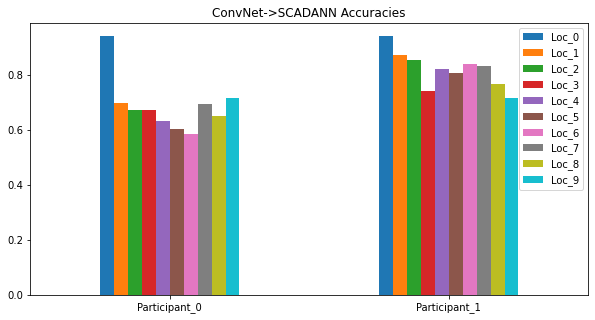

In [24]:
ConvNet_SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("ConvNet->SCADANN Accuracies")
plt.show()

In [25]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Sub"
n_name = "Loc"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_ConvNet_SCADANN, algo_name=algo_name)
df = pd.read_csv(save_ConvNet_SCADANN+'/'+algo_name+'.csv')
df

ground_truths  =  (2, 10)
predictions =  (2, 10)
index_participant_list  [0, 1, 2, 3, 4]
accuracies_gestures =  (22, 20)


Unnamed: 0  Sub0_Loc0  Sub0_Loc1  Sub0_Loc2  Sub0_Loc3  Sub0_Loc4  \
0          M0   1.000000   1.000000   1.000000   1.000000   1.000000   
1          M1   1.000000   0.153846   1.000000   1.000000   0.807692   
2          M2   0.576923   0.461538   0.000000   0.384615   0.923077   
3          M3   1.000000   0.884615   1.000000   1.000000   1.000000   
4          M4   0.923077   0.038462   0.076923   0.000000   0.000000   
5          M5   1.000000   1.000000   1.000000   0.923077   1.000000   
6          M6   0.923077   0.923077   0.807692   1.000000   1.000000   
7          M7   1.000000   0.884615   0.884615   1.000000   1.000000   
8          M8   0.961538   1.000000   0.961538   1.000000   0.961538   
9          M9   1.000000   0.307692   0.769231   1.000000   0.000000   
10        M10   1.000000   0.923077   0.961538   1.000000   0.115385   
11        M11   0.961538   0.307692   0.000000   0.000000   0.038462   
12        M12   0.769231   0.038462   0.038462   0.307692   0.038462   
13        M13   0.730769   1.000000   1.000000   1.000000   0.961538   
14        M14   0.923077   0.346154   0.153846   0.000000   0.000000   
15        M15   1.000000   0.115385   0.000000   0.076923   0.115385   
16        M16   1.000000   1.000000   1.000000   0.923077   1.000000   
17        M17   1.000000   1.000000   1.000000   1.000000   1.000000   
18        M18   1.000000   1.000000   0.846154   0.576923   1.000000   
19        M19   0.961538   1.000000   1.000000   1.000000   1.000000   
20        M20   1.000000   1.000000   0.384615   0.000000   1.000000   
21        M21   1.000000   1.000000   0.961538   0.615385   0.000000   
22       Mean   0.942308   0.699301   0.674825   0.673077   0.634615   

    Sub0_Loc5  Sub0_Loc6  Sub0_Loc7  Sub0_Loc8  ...  Sub1_Loc0  Sub1_Loc1  \
0    1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   
1    1.000000   1.000000   1.000000   0.884615  ...   0.961538   1.000000   
2    0.538462   0.653846   0.000000   0.884615  ...   1.000000   1.000000   
3    1.000000   0.730769   0.923077   1.000000  ...   1.000000   1.000000   
4    0.000000   0.230769   0.000000   0.269231  ...   1.000000   1.000000   
5    1.000000   0.000000   0.961538   1.000000  ...   0.884615   0.923077   
6    1.000000   1.000000   1.000000   1.000000  ...   0.769231   0.000000   
7    0.846154   1.000000   0.884615   0.807692  ...   1.000000   1.000000   
8    1.000000   1.000000   1.000000   1.000000  ...   1.000000   1.000000   
9    0.115385   0.000000   1.000000   0.923077  ...   1.000000   0.846154   
10   0.038462   0.000000   0.846154   0.000000  ...   0.653846   0.846154   
11   0.000000   0.038462   0.000000   0.000000  ...   1.000000   1.000000   
12   0.384615   0.153846   0.000000   0.000000  ...   1.000000   1.000000   
13   1.000000   0.807692   1.000000   0.692308  ...   1.000000   0.500000   
14   0.038462   0.076923   0.000000   0.000000  ...   0.615385   1.000000   
15   0.000000   0.153846   0.115385   0.000000  ...   1.000000   1.000000   
16   0.576923   1.000000   1.000000   1.000000  ...   0.923077   0.961538   
17   1.000000   0.961538   1.000000   0.961538  ...   1.000000   1.000000   
18   1.000000   0.884615   0.961538   0.923077  ...   1.000000   0.692308   
19   1.000000   0.307692   1.000000   0.961538  ...   1.000000   1.000000   
20   0.230769   0.846154   0.769231   0.961538  ...   1.000000   0.923077   
21   0.538462   1.000000   0.807692   0.076923  ...   0.923077   0.500000   
22   0.604895   0.583916   0.694056   0.652098  ...   0.942308   0.872378   

    Sub1_Loc2  Sub1_Loc3  Sub1_Loc4  Sub1_Loc5  Sub1_Loc6  Sub1_Loc7  \
0    1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
1    0.576923   1.000000   1.000000   1.000000   1.000000   1.000000   
2    0.961538   1.000000   0.846154   1.000000   1.000000   1.000000   
3    0.769231   0.923077   1.000000   1.000000   1.000000   0.923077   
4    0.846154   0.730769   0.807692   0.884615   0.500000   1.000

In [26]:
print("ConvNet")
display(ConvNet_df)
print("ConvNet->DANN")
display(ConvNet_DANN_df)
print("ConvNet->SCADANN")
display(ConvNet_SCADANN_df)

ConvNet


Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.604895      0.737762
Loc_2      0.503497      0.756993
Loc_3      0.545455      0.732517
Loc_4      0.505245       0.79021
Loc_5           0.5      0.772727
Loc_6      0.576923      0.685315
Loc_7       0.66958      0.744755
Loc_8       0.54021      0.534965
Loc_9      0.674825      0.711538

ConvNet->DANN


Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.718531      0.828671
Loc_2      0.582168      0.809441
Loc_3      0.666084      0.694056
Loc_4      0.587413      0.770979
Loc_5      0.513986      0.770979
Loc_6      0.617133      0.797203
Loc_7      0.662587      0.795455
Loc_8      0.585664      0.713287
Loc_9      0.736014      0.641608

ConvNet->SCADANN


Participant_0 Participant_1
Loc_0      0.942308      0.942308
Loc_1      0.699301      0.872378
Loc_2      0.674825      0.854895
Loc_3      0.673077      0.743007
Loc_4      0.634615      0.821678
Loc_5      0.604895      0.807692
Loc_6      0.583916      0.840909
Loc_7      0.694056      0.832168
Loc_8      0.652098      0.767483
Loc_9      0.718531      0.718531

In [27]:
overall_acc_df = pd.DataFrame([ConvNet_acc_overall, 
                               ConvNet_DANN_acc_overall, 
                               ConvNet_SCADANN_acc_overall],
                             index = ["ConvNet", "ConvNet_DANN", "ConvNet_SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

Overall_Acc
ConvNet             0.673601
ConvNet_DANN        0.718794
ConvNet_SCADANN     0.753934

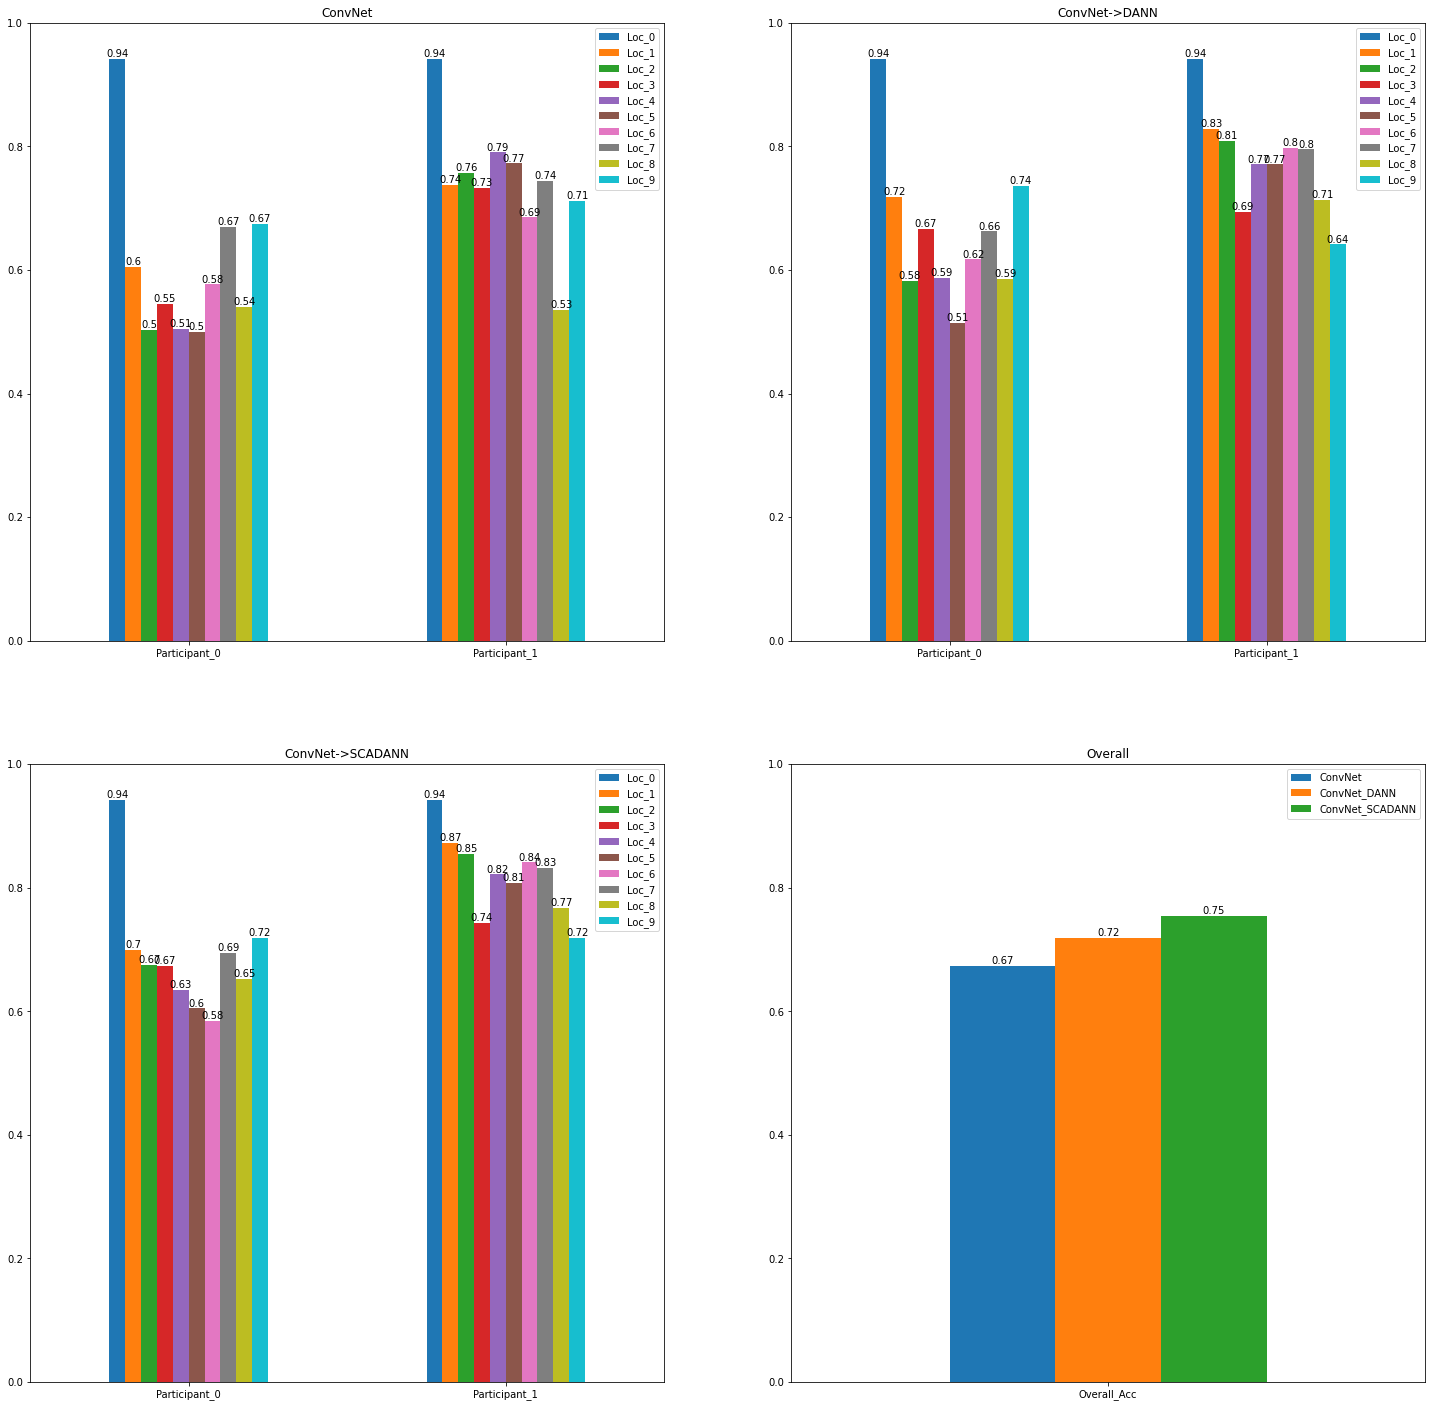

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,25))
acc_list = [ConvNet_df, ConvNet_DANN_df, ConvNet_SCADANN_df,overall_acc_df]
title_list = ["ConvNet", "ConvNet->DANN", "ConvNet->SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    if idx < len(acc_list):
        acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
        ax.set_title(title_list[idx])
        ax.set_ylim([0, 1.0])
        for p in ax.patches:
            ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                        ha='center', va='center', xytext=(0, 5),textcoords='offset points')

## Conclusion
Incorporating Shapley values into the gesture recognition pipeline not only improved model performance in domain adaptation scenarios but also enhanced the interpretability of the underlying decision making process. By identifying critical EMG channels for both gesture recognition and domain adaptation, this approach provides deeper insights into the model’s behavior. Moreover, fine-tuning model weights based on Shapley-derived importance scores allows for more robust, adaptive, and transparent EMG-based gesture recognition systems.


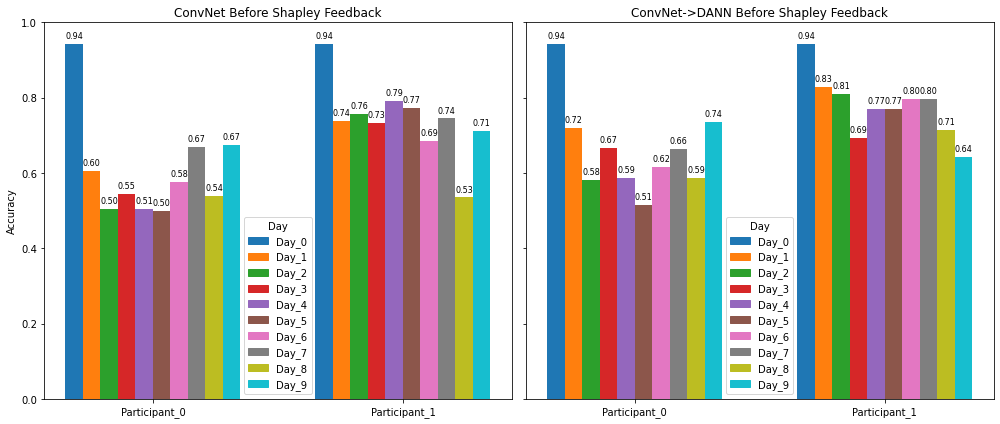

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Conv before Shapley feedback
conv_days = ["Day_0","Day_1","Day_2","Day_3","Day_4","Day_5","Day_6","Day_7","Day_8","Day_9"]
conv_P0 = [0.942308, 0.604895, 0.503497, 0.545455, 0.505245, 0.5,     0.576923, 0.66958,  0.54021,  0.674825]
conv_P1 = [0.942308, 0.737762, 0.756993, 0.732517, 0.79021,  0.772727, 0.685315, 0.744755, 0.534965, 0.711538]

# Data for DANN before Shapley feedback
dann_days = ["Day_0","Day_1","Day_2","Day_3","Day_4","Day_5","Day_6","Day_7","Day_8","Day_9"]
dann_P0 = [0.942308, 0.718531, 0.582168, 0.666084, 0.587413, 0.513986, 0.617133, 0.662587, 0.585664, 0.736014]
dann_P1 = [0.942308, 0.828671, 0.809441, 0.694056, 0.770979, 0.770979, 0.797203, 0.795455, 0.713287, 0.641608]

# Participants on the x-axis
participants = ["Participant_0", "Participant_1"]
x = np.arange(len(participants))  # [0, 1]

bar_width = 0.07  # Adjust for spacing
offsets = np.linspace(-((len(conv_days)-1)/2)*bar_width, ((len(conv_days)-1)/2)*bar_width, len(conv_days))

# Define a color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(conv_days)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# ------------------- LEFT SUBPLOT (Conv before Shapley feedback) -------------------
for i, day in enumerate(conv_days):
    ax1.bar(x[0] + offsets[i], conv_P0[i], width=bar_width, color=colors[i])
    ax1.bar(x[1] + offsets[i], conv_P1[i], width=bar_width, color=colors[i])

ax1.set_xticks(x)
ax1.set_xticklabels(participants)
ax1.set_title('ConvNet Before Shapley Feedback')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1)

# Add data labels on top of bars
for i, day in enumerate(conv_days):
    ax1.text(x[0] + offsets[i], conv_P0[i] + 0.01, f"{conv_P0[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax1.text(x[1] + offsets[i], conv_P1[i] + 0.01, f"{conv_P1[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Create custom legend handles with patches
legend_patches = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(len(conv_days))]
ax1.legend(legend_patches, conv_days, title="Day")

# ------------------- RIGHT SUBPLOT (DANN before Shapley feedback) -------------------
for i, day in enumerate(dann_days):
    ax2.bar(x[0] + offsets[i], dann_P0[i], width=bar_width, color=colors[i])
    ax2.bar(x[1] + offsets[i], dann_P1[i], width=bar_width, color=colors[i])

ax2.set_xticks(x)
ax2.set_xticklabels(participants)
ax2.set_title('ConvNet->DANN Before Shapley Feedback')
ax2.set_ylim(0,1)

# Add data labels on top of bars
for i, day in enumerate(dann_days):
    ax2.text(x[0] + offsets[i], dann_P0[i] + 0.01, f"{dann_P0[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax2.text(x[1] + offsets[i], dann_P1[i] + 0.01, f"{dann_P1[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Use the same legend approach for the second subplot
ax2.legend(legend_patches, dann_days, title="Day")

plt.tight_layout()
plt.show()


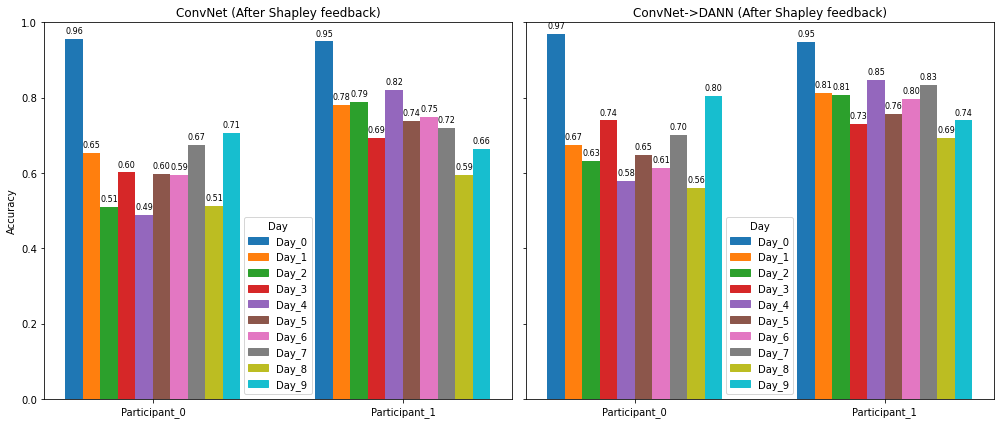

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data (after Shapley feedback)
# ConvNet after Shapley feedback:
conv_after_p0 = np.array([0.95629371, 0.65384615, 0.50874126, 0.6013986,  0.48951049,
                          0.59615385, 0.59440559, 0.67482517, 0.51223776, 0.70629371])
conv_after_p1 = np.array([0.9493007,  0.77972028, 0.78846154, 0.69230769, 0.81993007,
                          0.73776224, 0.75,       0.71853147, 0.59440559, 0.66433566])

# ConvNet->DANN after Shapley feedback:
dann_after_p0 = np.array([0.96853147, 0.67482517, 0.63286713, 0.73951049, 0.57867133,
                          0.64685315, 0.61363636, 0.70104895, 0.56118881, 0.8041958 ])
dann_after_p1 = np.array([0.94755245, 0.81293706, 0.80769231, 0.73076923, 0.84615385,
                          0.75699301, 0.79545455, 0.83391608, 0.69405594, 0.73951049])

# Days on which measurements were taken
days = [f"Day_{i}" for i in range(10)]

# Participants on the x-axis
participants = ["Participant_0", "Participant_1"]
x = np.arange(len(participants))  # [0, 1]

bar_width = 0.07  # spacing for bars
offsets = np.linspace(-((len(days)-1)/2)*bar_width, ((len(days)-1)/2)*bar_width, len(days))

# Define a color palette for the days
colors = plt.cm.tab10(np.linspace(0, 1, len(days)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)

# ------------------- LEFT SUBPLOT (ConvNet after Shapley feedback) -------------------
for i, day in enumerate(days):
    # Assign each day's bars the same color
    ax1.bar(x[0] + offsets[i], conv_after_p0[i], width=bar_width, color=colors[i])
    ax1.bar(x[1] + offsets[i], conv_after_p1[i], width=bar_width, color=colors[i])

ax1.set_xticks(x)
ax1.set_xticklabels(participants)
ax1.set_title('ConvNet (After Shapley feedback)')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0,1)

# Add data labels on top of bars
for i, day in enumerate(days):
    ax1.text(x[0] + offsets[i], conv_after_p0[i] + 0.01, f"{conv_after_p0[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax1.text(x[1] + offsets[i], conv_after_p1[i] + 0.01, f"{conv_after_p1[i]:.2f}", ha='center', va='bottom', fontsize=8)

# Create legend handles
legend_patches = [plt.Rectangle((0,0),1,1,color=colors[i]) for i in range(len(days))]
ax1.legend(legend_patches, days, title="Day")

# ------------------- RIGHT SUBPLOT (ConvNet->DANN after Shapley feedback) -------------------
for i, day in enumerate(days):
    # Assign each day's bars the same color
    ax2.bar(x[0] + offsets[i], dann_after_p0[i], width=bar_width, color=colors[i])
    ax2.bar(x[1] + offsets[i], dann_after_p1[i], width=bar_width, color=colors[i])

ax2.set_xticks(x)
ax2.set_xticklabels(participants)
ax2.set_title('ConvNet->DANN (After Shapley feedback)')
ax2.set_ylim(0,1)

# Add data labels on top of bars
for i, day in enumerate(days):
    ax2.text(x[0] + offsets[i], dann_after_p0[i] + 0.01, f"{dann_after_p0[i]:.2f}", ha='center', va='bottom', fontsize=8)
    ax2.text(x[1] + offsets[i], dann_after_p1[i] + 0.01, f"{dann_after_p1[i]:.2f}", ha='center', va='bottom', fontsize=8)

ax2.legend(legend_patches, days, title="Day")

plt.tight_layout()
plt.show()


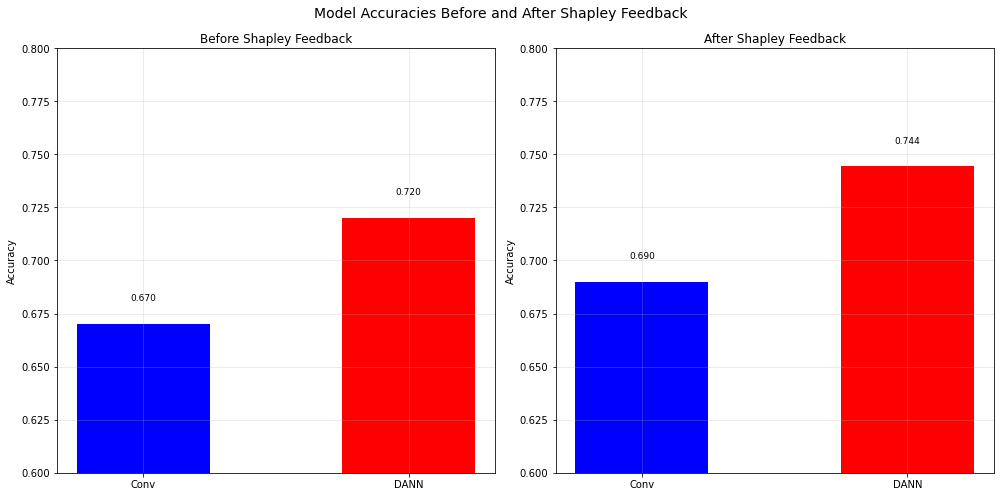

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Conv', 'DANN']
before_values = [0.67, 0.72]
after_values = [0.69, 0.7443]

# Colors: Conv = blue, DANN = red
model_colors = {'Conv': 'blue', 'DANN': 'red'}

# Increase figure size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Left subplot - Before Shapley Feedback
colors_before = [model_colors[m] for m in models]
ax1.bar(models, before_values, width=0.5, color=colors_before)
ax1.set_title('Before Shapley Feedback', fontsize=12)
ax1.set_ylim(0.6, 0.8)
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('Accuracy', fontsize=10)

# Add value labels on the bars
for i, v in enumerate(before_values):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Right subplot - After Shapley Feedback
colors_after = [model_colors[m] for m in models]
ax2.bar(models, after_values, width=0.5, color=colors_after)
ax2.set_title('After Shapley Feedback', fontsize=12)
ax2.set_ylim(0.6, 0.8)
ax2.grid(True, alpha=0.3)
ax2.set_ylabel('Accuracy', fontsize=10)

# Add value labels on top of bars
for i, v in enumerate(after_values):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Overall title
fig.suptitle('Model Accuracies Before and After Shapley Feedback', fontsize=14)

plt.tight_layout()
plt.show()


## Brief Summary
The above graphs demonstrate clear improvements in model accuracy following the incorporation of Shapley feedback. After implementation, both architectures showed consistent performance gains of approximately 2%, with ConvNet improving from 67% to 69% (before transfer learning), and DANN advancing from 72% to 74% (transfer learning). This parallel improvement suggests the effectiveness of Shapley feedback across different model architectures. Throughout the experiments, Participant_1 exhibited notably better and more stable performance compared to Participant_0 across both models and time periods. The introduction of Shapley feedback not only enhanced overall accuracy, but also contributed to more stable day-to-day performance variations, with this stabilizing effect being particularly pronounced in the DANN model's results. 

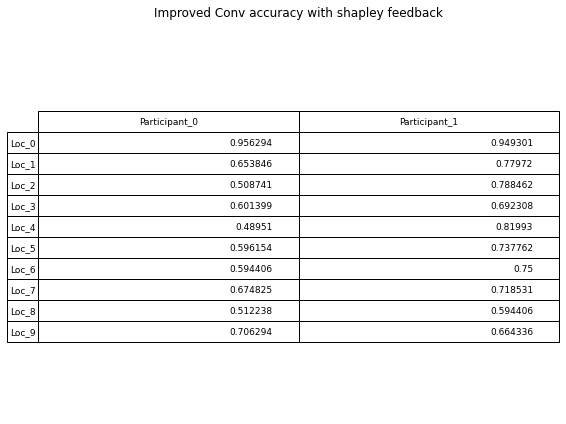


DataFrame:
       Participant_0  Participant_1
Loc_0       0.956294       0.949301
Loc_1       0.653846       0.779720
Loc_2       0.508741       0.788462
Loc_3       0.601399       0.692308
Loc_4       0.489510       0.819930
Loc_5       0.596154       0.737762
Loc_6       0.594406       0.750000
Loc_7       0.674825       0.718531
Loc_8       0.512238       0.594406
Loc_9       0.706294       0.664336


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the data arrays
participant_0 = np.array([0.95629371, 0.65384615, 0.50874126, 0.6013986, 0.48951049,
                         0.59615385, 0.59440559, 0.67482517, 0.51223776, 0.70629371])
participant_1 = np.array([0.9493007, 0.77972028, 0.78846154, 0.69230769, 0.81993007,
                         0.73776224, 0.75, 0.71853147, 0.59440559, 0.66433566])

# Create DataFrame
df = pd.DataFrame({
    'Participant_0': participant_0,
    'Participant_1': participant_1
}, index=[f'Loc_{i}' for i in range(10)])

# Now you can create the plot using the DataFrame
plt.figure(figsize=(8, 6))

# Create table from DataFrame
table = plt.table(cellText=df.round(6).values,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='right')

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

# Remove axes
plt.axis('off')

# Add title
plt.title('Improved Conv accuracy with shapley feedback', pad=20)

plt.tight_layout()
plt.show()

# You can also display the DataFrame directly:
print("\nDataFrame:")
print(df)

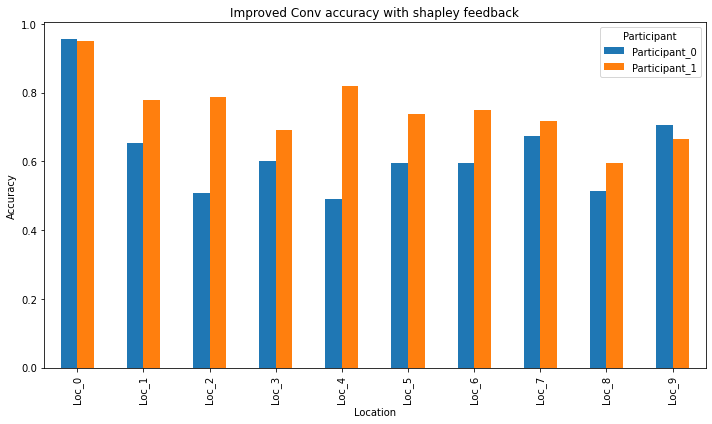

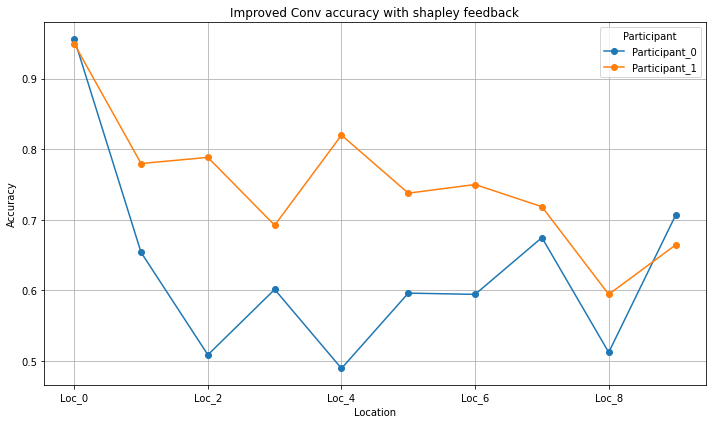

In [19]:
# Bar plot
df.plot(kind='bar', figsize=(10, 6))
plt.title('Improved Conv accuracy with shapley feedback')
plt.xlabel('Location')
plt.ylabel('Accuracy')
plt.legend(title='Participant')
plt.tight_layout()
plt.show()

# Line plot
df.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Improved Conv accuracy with shapley feedback')
plt.xlabel('Location')
plt.ylabel('Accuracy')
plt.legend(title='Participant')
plt.grid(True)
plt.tight_layout()
plt.show()

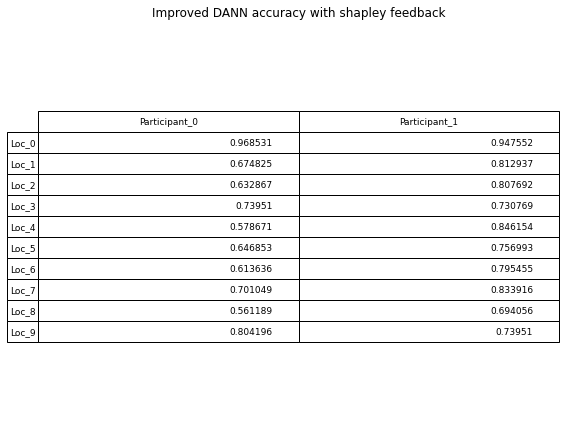

<Figure size 720x432 with 0 Axes>

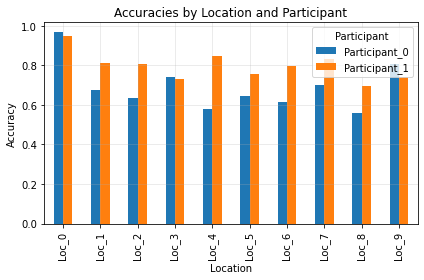

<Figure size 720x432 with 0 Axes>

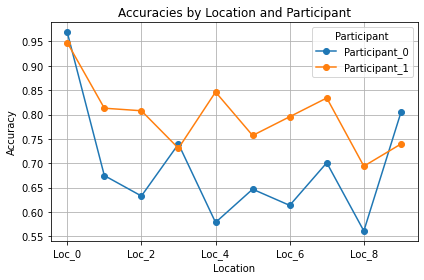


DataFrame:
       Participant_0  Participant_1
Loc_0       0.968531       0.947552
Loc_1       0.674825       0.812937
Loc_2       0.632867       0.807692
Loc_3       0.739510       0.730769
Loc_4       0.578671       0.846154
Loc_5       0.646853       0.756993
Loc_6       0.613636       0.795455
Loc_7       0.701049       0.833916
Loc_8       0.561189       0.694056
Loc_9       0.804196       0.739510


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the data arrays
accuracies = np.array([
    [0.96853147, 0.67482517, 0.63286713, 0.73951049, 0.57867133, 0.64685315,
     0.61363636, 0.70104895, 0.56118881, 0.8041958],
    [0.94755245, 0.81293706, 0.80769231, 0.73076923, 0.84615385, 0.75699301,
     0.79545455, 0.83391608, 0.69405594, 0.73951049]
])

# Create DataFrame
df = pd.DataFrame(accuracies.T,  # Transpose to get locations as rows
                 columns=['Participant_0', 'Participant_1'],
                 index=[f'Loc_{i}' for i in range(10)])

# Create table plot
plt.figure(figsize=(8, 6))
table = plt.table(cellText=df.round(6).values,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 loc='center',
                 cellLoc='right')

# Adjust table properties
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

plt.axis('off')
plt.title('Improved DANN accuracy with shapley feedback', pad=20)
plt.tight_layout()
plt.show()



# Bar plot
plt.figure(figsize=(10, 6))
df.plot(kind='bar')
plt.title('Accuracies by Location and Participant')
plt.xlabel('Location')
plt.ylabel('Accuracy')
plt.legend(title='Participant')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Line plot
plt.figure(figsize=(10, 6))
df.plot(kind='line', marker='o')
plt.title('Accuracies by Location and Participant')
plt.xlabel('Location')
plt.ylabel('Accuracy')
plt.legend(title='Participant')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the DataFrame
print("\nDataFrame:")
print(df)